**Boost Ideal CCM**

Dados los datos: 
- $F_{sw} = 40kHz$
- $V_d = 6V$
- $V_o = 15V$
- $\frac{\Delta V_o}{V_o} = 7\%$
- $V_{GG} = 18V$

Obtenemos:

In [1]:
import numpy as np

# Data
fsw = 40E3
Ts = 1/fsw
Vd = 6
Vo = 15
Vo_ripple = 0.07
Delta_Vo = Vo*Vo_ripple
VGG = 18

L = 220E-6
L_tol = 0.1
L_Q = 20
R_L = 2*np.pi*fsw*L/L_Q
ESR = 0.8
C = 10E-6

In [2]:
from utils import to_unit
from boost import *

# Definir una R de carga
R = 500
Io = Vo/R
print('Io = ' + to_unit(Io) + 'A')

# Calculamos D inicial
D = 1 - Vd/Vo

# Averiguamos si estamos en CCM o DCM
Iob = Vo*Ts*((1-D)**2)*D / (2*L)
print('Iob = ' + to_unit(Iob) + 'A')
print('')

if Io >= Iob:
    # Estamos en CCM
    print("Boost CCM")
    print(f'D = {D:.2g}')

    Ix = Io/(1-D)
    print('Ix = ' + to_unit(Ix) + 'A')
    
    Delta_Il = (Vd/L)*D*Ts
    print('Delta_IL = ' + to_unit(Delta_Il) + 'A')
    
    IL_max = Ix + Delta_Il/2
    print('IL_max = ' + to_unit(IL_max) + 'A')

    # Calculo Delta Q
    Delta_Q = CCM_get_Delta_Q(Vd, Vo, D, Ts, L, Io)

else:
    # Estamos en DCM
    print("Boost DCM")
    
    # Tiempos
    D = np.sqrt(( 2*L*Io / (Vd*Ts)) * (Vo/Vd - 1))
    Delta_1 = 2*L*Io / (Vd*D*Ts)
    print(f'D = {D:.2g}')
    print(f'Delta_1 = {Delta_1:.2g}')
    
    # Corrientes
    Delta_Il = (Vd/L)*D*Ts
    print('Delta_IL = ' + to_unit(Delta_Il) + 'A')
    IL_max = Delta_Il
    print('IL_max = ' + to_unit(IL_max) + 'A')
    
	# Calculo Delta Q
    Delta_Q = DCM_get_Delta_Q(Vd, Vo, D, Ts, L, Io)
    
Delta_Vc = Delta_Vo - Delta_Il*ESR
C = Delta_Q/Delta_Vc
print('C = ' + to_unit(C) + 'F')    
    
print('Po = ' + to_unit(Vo**2/R) + 'W')

Io = 30mA
Iob = 81.8mA

Boost DCM
D = 0.36
Delta_1 = 0.24
Delta_IL = 248mA
IL_max = 248mA
C = 680nF
Po = 450mW


# Gráficos

In [3]:
from utils import *
import matplotlib.pyplot as plt

def plot_curve(ax, t, x, D, Ts, Delta_1=0):
    ax.plot(t, x)
    xticks = list(set([i*Ts + j*Ts for i in range(int(t[-1]/Ts + 1)) for j in [0, D, D + Delta_1] if (i*Ts + j*Ts) < t[-1]]))	# No la pienses, solo confiá
    _, exp = get_exp(t[-1])
    xticks_label = [f'{round(i/(1000**exp))}' for i in xticks]
    ax.set_xticks(xticks, xticks_label)
    ax.set_xlabel('t [' + get_unit_prefix(t[-1]) + 's]')
    ax.grid()

In [4]:
from utils import *
from boost import *
import matplotlib.pyplot as plt

# Definir una R de carga
R = 500
Io = Vo/R
print('Io = ' + to_unit(Io) + 'A')
D = 1 - Vd/Vo
Iob = Vo*Ts*((1-D)**2)*D / (2*L)
if Io >= Iob:       # If CCM
    Delta_1 = 0
else: 				# If DCM
	D = np.sqrt(( 2*L*Io / (Vd*Ts)) * (Vo/Vd - 1))
	Delta_1 = 2*L*Io / (Vd*D*Ts)
Ix = Io/(1-D)

# Vector de tiempo
periods = 2.2
t = np.linspace(0, periods*Ts, 1000)

print('Po =', Vo**2/R, 'W')

Io = 30mA
Po = 0.45 W


### Curvas inductor

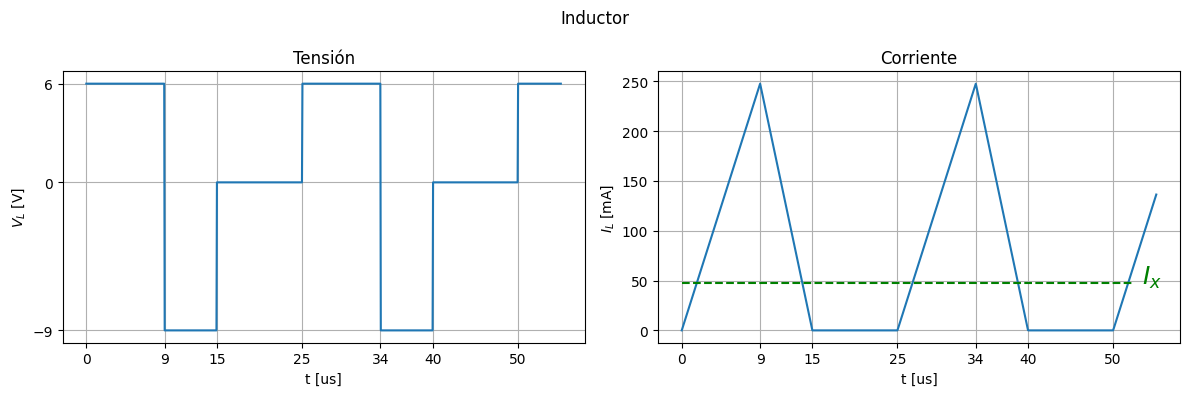

In [5]:
# CURVAS INDUCTOR
VL = [get_VL(Vd, Vo, L, Ts, Io, ti) for ti in t]
IL = [get_IL(Vd, Vo, L, Ts, Io, ti) for ti in t]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Inductor')

# Plot VL
ax[0].set_title('Tensión')
plot_curve(ax[0], t, VL, D, Ts, Delta_1)
ax[0].set_ylabel('$V_L$ [' + get_unit_prefix(max(VL)) + 'V]')
ax[0].set_yticks([Vd, 0, -(Vo-Vd)])

# Plot IL
ax[1].set_title('Corriente')
plot_curve(ax[1], t, IL, D, Ts, Delta_1)
ax[1].set_ylabel('$I_L$ [' + get_unit_prefix(max(IL)) + 'A]')
yticks = ax[1].get_yticks()[1:-1]
_, exp = get_exp(max(IL))
ax[1].set_yticks(yticks, [f'{i/(1000**exp):g}' for i in yticks])

# Plot Ix
ax[1].plot(t[0:-50], Ix*np.ones_like(t[0:-50]), color='green', linestyle='--')
ax[1].annotate('$I_x$', xy=(t[-50], Ix), xytext=(t[-30], Ix), color='green', fontsize=18)

fig.tight_layout()


### Curvas switch

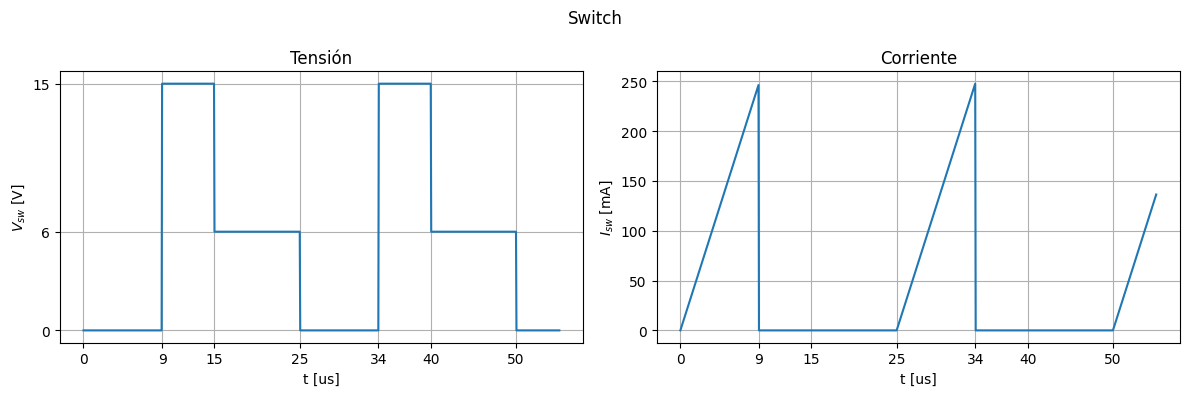

In [6]:
# CURVAS SWITCH
Vsw = [get_Vsw(Vd, Vo, L, Ts, Io, ti) for ti in t]
Isw = [get_Isw(Vd, Vo, L, Ts, Io, ti) for ti in t]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Switch')

# Plot Vsw
ax[0].set_title('Tensión')
plot_curve(ax[0], t, Vsw, D, Ts, Delta_1)
ax[0].set_ylabel('$V_{sw}$ [' + get_unit_prefix(max(Vsw)) + 'V]')
ax[0].set_yticks([0, Vo, Vd])

# Plot Isw
ax[1].set_title('Corriente')
plot_curve(ax[1], t, Isw, D, Ts, Delta_1)
ax[1].set_ylabel('$I_{sw}$ [' + get_unit_prefix(max(Isw)) + 'A]')
yticks = ax[1].get_yticks()[1:-1]
_, exp = get_exp(max(Isw))
ax[1].set_yticks(yticks, [f'{i/(1000**exp):g}' for i in yticks])

fig.tight_layout()


### Curvas diodo

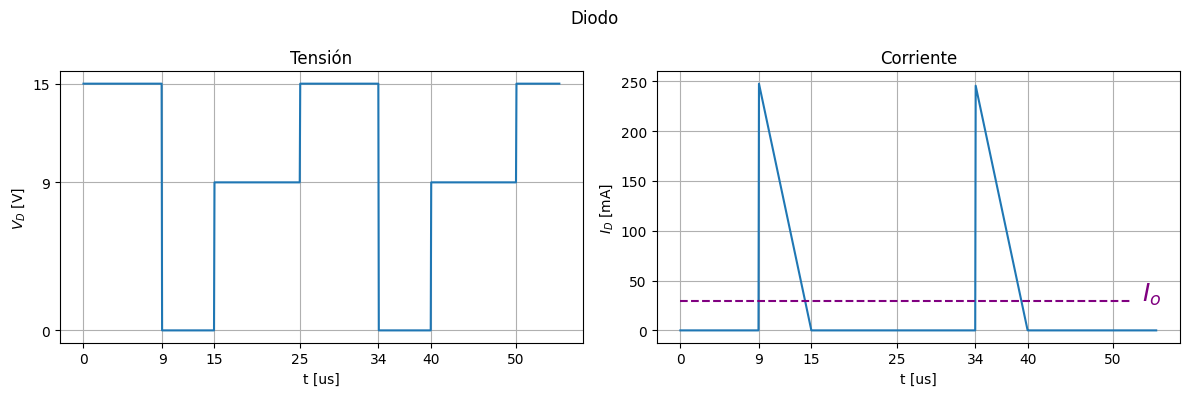

In [7]:
# CURVAS DIODO
ID = [get_ID(Vd, Vo, L, Ts, Io, ti) for ti in t]
VD = [get_VD(Vd, Vo, L, Ts, Io, ti) for ti in t]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Diodo')

# Plot VD
ax[0].set_title('Tensión')
plot_curve(ax[0], t, VD, D, Ts, Delta_1)
ax[0].set_ylabel('$V_D$ [' + get_unit_prefix(max(VD)) + 'V]')
ax[0].set_yticks([Vo, 0, Vo-Vd])

# Plot ID
ax[1].set_title('Corriente')
plot_curve(ax[1], t, ID, D, Ts, Delta_1)
ax[1].set_ylabel('$I_D$ [' + get_unit_prefix(max(ID)) + 'A]')
yticks = ax[1].get_yticks()[1:-1]
_, exp = get_exp(max(ID))
ax[1].set_yticks(yticks, [f'{i/(1000**exp):g}' for i in yticks])

# Plot Io
ax[1].plot(t[0:-50], Io*np.ones_like(t[0:-50]), color='purple', linestyle='--')
ax[1].annotate('$I_o$', xy=(t[-50], Io), xytext=(t[-30], Io), color='purple', fontsize=18)

fig.tight_layout()


### Curvas capacitor

14.984265757036718


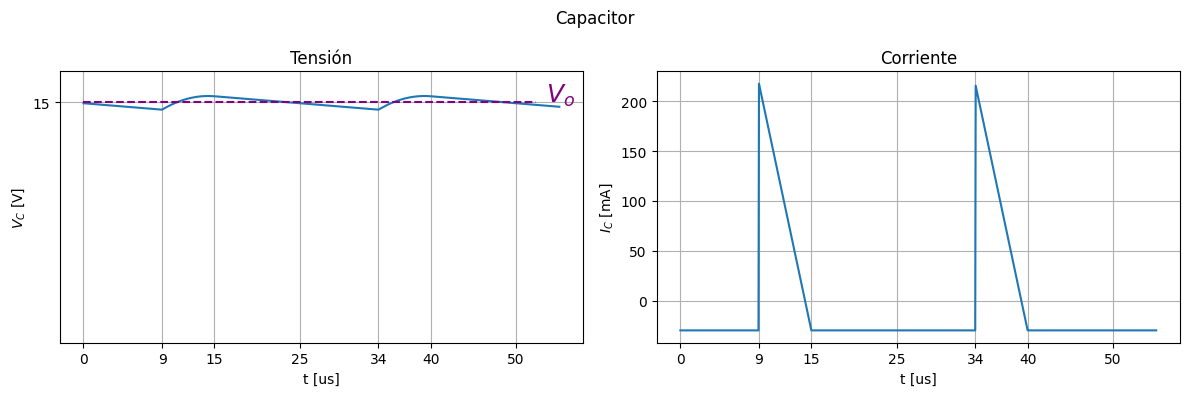

In [9]:
# CURVAS CAPACITOR
VC = [get_VC(Vd, Vo, L, C, Ts, Io, ti) for ti in t]
IC = [get_IC(Vd, Vo, L, Ts, Io, ti) for ti in t]

# Adjust mean value (<Vc> = Vo)
VC = VC  + (-np.mean(VC[0:int(int(periods)*1000/periods)]) + Vo)*np.ones_like(VC)
print(np.mean(VC))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Capacitor')

# Plot VC
ax[0].set_title('Tensión')
plot_curve(ax[0], t, VC, D, Ts, Delta_1)
ax[0].set_ylabel('$V_C$ [' + get_unit_prefix(max(VC)) + 'V]')
# ax[0].set_yticks([Vo])
# ax[0].set_ylim([0, max(VC)*1.1])

# # Plot Vo
ax[0].plot(t[0:-50], Vo*np.ones_like(t[0:-50]), color='purple', linestyle='--')
ax[0].annotate('$V_o$', xy=(t[-50], Vo), xytext=(t[-30], Vo), color='purple', fontsize=18)

# Plot IC
ax[1].set_title('Corriente')
plot_curve(ax[1], t, IC, D, Ts, Delta_1)
ax[1].set_ylabel('$I_C$ [' + get_unit_prefix(max(IC)) + 'A]')
yticks = ax[1].get_yticks()[1:-1]
_, exp = get_exp(max(IC))
ax[1].set_yticks(yticks, [f'{i/(1000**exp):g}' for i in yticks])

fig.tight_layout()